In [1]:
# PlotCABLEModelObs.ipynb
# Plot observations and observables consistent with PEST format
# Assume one set of observations but possibly multiple sets of model observables

In [2]:
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import pandas as pd
import numpy as np
import os.path
import datetime
import matplotlib.dates as mdates
from pandas.tseries import converter  # these two lines needed to allow datetime64 to plot properly
converter.register()
%matplotlib inline
ndaysinmonth = [31,28,31,30,31,30,31,31,30,31,30,31];

In [3]:
# Define dictionary to relate variable codes and variable names
varname = {     
   'GPP': 'GPP',
   'NEP': 'NEP',
   'EvT': 'Evapotranspiration',
   'Rec': 'Ecosystem Respiration',
   'Rso': 'Soil Respiration',
   'LAI': 'Leaf area index', 
   'SMC': 'Soil moisture (CosmOz)',
   'SMO': 'Soil moisture (OzNet)',
   'SMF': 'Soil moisture (OzFlux)',
   'STR': 'Streamflow [mm/d]',  
   'ET':  'ET [mm/d]',
   'SC0': "Soil carbon density \n in top 15cm [gC/kg]",
   'Lit': 'Above-ground \n litter [tC/ha]',
   'Phy': 'Above-ground \n phytomass [tC/ha]',
   'NPP': 'Leaf NPP [tC/ha/yr]',
   'LBA': 'Basal area [m2/ha]',
   'LTD': 'Live tree number \n density [n/ha]', 
   'AGD': 'Above-ground \n drymass [Mg/ha]',
    }
varname.get('oth','oth')

'oth'

In [4]:
# Define dictionary to relate site codes and site names
sitename = {
    'Ade': 'Adelaide River',
    'How': 'Howard Springs',
    'ASM': 'Alice Springs',
    'Nim': 'Nimmo',
    'Cpr': 'Calperum',
    'Stp': 'Sturt Plains',
    'DaP': 'Daly River Uncleared',
    'Tum': 'Tumbarumba',
    'Dry': 'DryCreek',
    'Wal': 'Wallaby Creek',
    'GNA': 'Gnangara',
    'Whr': 'Whroo',  
    'GWW': 'Great Western Woodland',  
    'Wom': 'Wombat',  
    'Yan': 'Yanco', 
    'Dal': 'Daly', 
    'Wea': 'Weany', 
    'Rob': 'Robson', 
    'Cum': 'Cumberland Plains',
    'War': 'Warra',
    '410061': '410061 (Adelong Ck)', 
    '815018': '815018 (Elisabeth R)', 
    'A3_': 'A3',
    'K2_': 'K2',
    'K3_': 'K3',
    'A1_': 'A1',  
}
sitename.get('Ade','Ade')

'Adelaide River'

In [5]:
# Functions to extract information from obsname and obsinfo
def sitelen(obstype):  # returns length (number of characters) of sitename string in obsname
    sl = 3
    if any(obstype in s for s in ['SC0','Phy','Lit','NPP']):
        sl = 4
    if any(obstype in s for s in ['LBA','LTD','AGD']):
        sl = 5
    if (obstype == 'STR'):
        sl = 6 
    return sl    

def extractobstype(obsname):  # extract obstype from obsname
    obstype = obsname[:3]    
    return obstype

def extractsite(row):   # extract site name from obsname
    site = row['obsname'][3:3+sitelen(row['obstype'])]
    site = sitename.get(site,site)
    if (row['obstype'] == 'SMO'):  # append soil moisture depth range to OzNet site names
        Lpos = row['obsname'].find('L')   
        dep1 = row['obsname'][Lpos+1:Lpos+3]
        dep2 = row['obsname'][Lpos+3:Lpos+5]
        if (dep1[0:1] == '0'): 
            dep1 = dep1[1] 
        if (dep2[0:1] == '0'):
            dep2 = dep2[1] 
        site = site + " " + dep1 + '-' + dep2 + 'cm'
    return site

def extractpatch(row):   # extract patch from obsinfo (1,2,3 or 'a' for average and 'p' for reweighted average)
    patch = '1'
    Ppos = row['obsinfo'].find('P')   
    if (Ppos > 0):
        patch = row['obsinfo'][Ppos+1:Ppos+2]
    return patch

def extractproc(row):   # extract processing type from obsinfo 
    proc = row['obsinfo'][0:3]
    return proc

def extractBiome(row):   # extract biome from obsname
    biome = '00'
    Bpos = row['obsinfo'].find('B')   
    if (Bpos > 0):
        biome = row['obsinfo'][Bpos+1:Bpos+3]    
    return biome

def extractReccap(row):   # extract recccap ID from obsname
    reccap = '0'
    Rpos = row['obsinfo'].find('R')   
    if (Rpos > 0):
        reccap = row['obsinfo'][Rpos+1:Rpos+2]    
    return reccap

def extractNVIS(row):   # extract NVIS classification from obsname
    nvis = '00'
    Npos = row['obsinfo'].find('N')   
    if (Npos > 0):
        nvis = row['obsinfo'][Npos+1:Npos+3]
    return nvis

def extractDMYR(row):   # extract time-averaging info (day, mon, year or run) from obsname
    DMYR = row['obsname'][sitelen(row['obstype'])+3:sitelen(row['obstype'])+4]    
    return DMYR

def extractdate(row):   # extract date from obsname
    hour = 0
    minute = 0
    if ((row['DMYR'] == 'R') or (row['DMYR'] == 'I')):  # run average or initial value from POP file
        year = 1990
        month = 1
        day = 1
    if (row['DMYR'] == 'Y'):
        year = int(row['obsname'][sitelen(row['obstype'])+4:sitelen(row['obstype'])+8])
        month = 6
        day = 30
    if (row['DMYR'] == 'M'):
        year = int(row['obsname'][sitelen(row['obstype'])+4:sitelen(row['obstype'])+8])
        month = int(row['obsname'][sitelen(row['obstype'])+8:sitelen(row['obstype'])+10])   
        day = 15
    if (row['DMYR'] == 'B'):  # bi-monthly
        year = int(row['obsname'][sitelen(row['obstype'])+4:sitelen(row['obstype'])+8])
        month = int(row['obsname'][sitelen(row['obstype'])+8:sitelen(row['obstype'])+10])   
        day = day = int(row['obsname'][sitelen(row['obstype'])+10:sitelen(row['obstype'])+12])+7    
    if (row['DMYR'] == 'D'):
        year = int(row['obsname'][sitelen(row['obstype'])+4:sitelen(row['obstype'])+8])
        month = int(row['obsname'][sitelen(row['obstype'])+8:sitelen(row['obstype'])+10])  
        day = int(row['obsname'][sitelen(row['obstype'])+10:sitelen(row['obstype'])+12]) 
    if (row['DMYR'] == 'H'):   # hourly
        year = int(row['obsname'][sitelen(row['obstype'])+4:sitelen(row['obstype'])+8])
        month = int(row['obsname'][sitelen(row['obstype'])+8:sitelen(row['obstype'])+10])  
        day = int(row['obsname'][sitelen(row['obstype'])+10:sitelen(row['obstype'])+12]) 
        hour = int(row['obsname'][sitelen(row['obstype'])+12:sitelen(row['obstype'])+14])
    if (row['DMYR'] == 'F'):  # half-hourly
        year = int(row['obsname'][sitelen(row['obstype'])+4:sitelen(row['obstype'])+8])
        month = int(row['obsname'][sitelen(row['obstype'])+8:sitelen(row['obstype'])+10])  
        day = int(row['obsname'][sitelen(row['obstype'])+10:sitelen(row['obstype'])+12]) 
        hour = int(row['obsname'][sitelen(row['obstype'])+12:sitelen(row['obstype'])+14])  
        minute = int(row['obsname'][sitelen(row['obstype'])+14:sitelen(row['obstype'])+16])
    date = datetime.datetime(year,month,day,hour,minute)
    return (date)

def extractarea(row):   # extract catchment area from obsinfo (for streamflow obs only)
    area = 0
    if (row['obstype'] == 'STR'):
        Ppos = row['obsinfo'].find('P')   
        if (Ppos > 0):
            area = int(row['obsinfo'][Ppos+2:])  
    return area

In [6]:
def GetCatchProperties(df):  # read catchment properties from Catchment_gridcells.txt
    verbose = True
    df['precip'] = 0.0
    print('Processing Catchment_gridcells.txt file')
    f = open(mypath+'Catchment_gridcells.txt', "r")
    ncatch = int(f.readline().strip())   # first line of input file
    if (verbose):
        print(ncatch,' catchments')
        print('--------------------------------------------------------')
    for ic in range(ncatch):
        line = f.readline()
        xx = line.split()
        cname = xx[0]
        cname = sitename.get(cname,cname)
   #     print('Catchment = ',cname)
        ngridcells = int(xx[1])
   #     print(ngridcells,' gridcells')
        df_catch = pd.DataFrame(columns=['biome','nvis','reccap'])
        for ig in range(ngridcells):
            line = f.readline()
            yy = line.split()
            gridcell = int(yy[0])
            biome = int(yy[1])
            nvis = int(yy[2])
            reccap = int(yy[3])
            df_catch.loc[ig,'biome'] = str(int(biome)).zfill(2)
            df_catch.loc[ig,'nvis'] = str(int(nvis)).zfill(2)
            df_catch.loc[ig,'reccap'] = str(int(reccap))
        precip = float(f.readline().strip())
     #   if (verbose):    
    #        print('biome mode=')
    #        print(df_catch['biome'].value_counts())
    #        print('nvis mode=')
    #        print(df_catch['nvis'].value_counts())
    #        print('reccap mode=')
    #        print(df_catch['reccap'].value_counts())
    #        print('precip = ',precip)
    #        print('--------------------------------------------------------')
        df.loc[df['site'] == cname,['precip']] = precip
        df.loc[df['site'] == cname,['biome']] = df_catch['biome'].mode()[0]
        df.loc[df['site'] == cname,['nvis']] = df_catch['nvis'].mode()[0]
        df.loc[df['site'] == cname,['reccap']] = df_catch['reccap'].mode()[0]
    f.close()
    return(df)

In [7]:
# Read PEST observation file, containing observations plus information about them
def ReadPESTObservations(flnm,leapflag,ColourBy):
    print("Read observations from file ",flnm)    
    df = pd.read_fwf(flnm,widths=[20,16,16,11,21],skiprows=1,header=None,
                        names=['obsname', 'obs', 'weight', 'obsgrp', 'obsinfo']) 
    nobs = len(df.index)
    print(nobs,' observations')  
    df['obstype'] = df.apply(lambda row: extractobstype(row['obsname']),axis=1)
    df['site'] = df.apply(lambda row: extractsite(row),axis=1)
    df['DMYR'] = df.apply(lambda row: extractDMYR(row),axis=1)
    df['date'] = df.apply(lambda row: extractdate(row),axis=1)
    df['patch'] = df.apply(lambda row: extractpatch(row),axis=1)
    df['proc'] = df.apply(lambda row: extractproc(row),axis=1)
    df['reccap'] = df.apply(lambda row: extractReccap(row),axis=1)
    df['biome'] = df.apply(lambda row: extractBiome(row),axis=1)
    df['nvis'] = df.apply(lambda row: extractNVIS(row),axis=1)
    df['area'] = df.apply(lambda row: extractarea(row),axis=1)
    dfSTR = df.loc[df['obstype'] == 'STR']
    if (len(dfSTR) != 0):
        df = GetCatchProperties(df)
    return df          

In [8]:
# Read model observables corresponding to observations
def ReadModel(flnm,modname):
    print("Read model observables from file ", flnm," for model",modname)
    s = pd.read_fwf(flnm,widths=[16],skiprows=1,header=None,names=[modname])
    print(len(s),'model observables')
    return s

In [9]:
dict_nvis_color = {'01': 'xkcd:lime',     # Rainforests and Vine Thickets
                   '02': 'xkcd:red',          # Eucalypt Tall Open Forests
                   '03': 'xkcd:aqua',       # Eucalypt Open Forests
                   '04': 'xkcd:orange',       # Eucalypt Low Open Forests
                   '05': 'xkcd:teal',         # Eucalypt Woodlands
                   '06': 'xkcd:tan',          # Acacia Forests and Woodlands
                   '07': 'xkcd:chartreuse', # Callitris Forests and Woodlands
                   '08': 'xkcd:lavender',     # Casuarina Forests and Woodlands
                   '09': 'xkcd:royal blue',   # Melaleuca Forests and Woodlands   
                   '10': 'xkcd:green',        # Other Forests and Woodlands
                   '11': 'xkcd:hot pink',     # Eucalypt Open Woodlands
                   '12': 'xkcd:olive',        # Tropical Eucalypt Woodlands/Grasslands
                   '13': 'xkcd:salmon',       # Acacia Open Woodlands
                   '14': 'xkcd:brown',        # Mallee Woodlands and Shrublands
                   '15': 'xkcd:bright blue',  # Low Closed Forests and Tall Closed Shrublands
                   '16': 'xkcd:grey',         # Acacia Shrublands
                   '17': 'xkcd:dark orange',  # Other Shrublands
                   '18': 'xkcd:lime',         # Heathlands
                   '19': 'xkcd:yellow',         # Tussock Grasslands
                   '20': 'xkcd:pale pink',    # Hummock Grasslands
                   '21': 'xkcd:neon purple',  # Other Grasslands, Herblands, Sedgelands and Rushlands
                   '22': 'xkcd:puke green',   # Chenopod Shrublands, Samphire Shrublands and Forblands
                   '23': 'xkcd:navy',         # Mangroves
                   '24': 'xkcd:gold',         # Inland Aquatic - freshwater, salt lakes, lagoon
                   '26': 'xkcd:sky blue',     # Unclassified Native Vegetation
                   '27': 'xkcd:khaki', # Naturally Bare - sand, rock, claypan, mudflat
                   '28': 'xkcd:dark red',      # Sea and Estuaries
                   '30': 'xkcd:palevioletred',# Unclassified Forest
                   '31': 'xkcd:sea green', # Other Open Woodlands
                   '32': 'xkcd:tomato',       # Mallee Open Woodlands and Sparse Mallee Shrublands
                   }

dict_nvis_name = {'01': 'Rainforests and Vine Thickets', 
                  '02': 'Eucalypt Tall Open Forests', 
                  '03': 'Eucalypt Open Forests',
                  '04': 'Eucalypt Low Open Forests',
                  '05': 'Eucalypt Woodlands',
                  '06': 'Acacia Forests and Woodlands',
                  '07': 'Callitris Forests and Woodlands',
                  '08': 'Casuarina Forests and Woodlands',
                  '09': 'Melaleuca Forests and Woodlands',
                  '10': 'Other Forests and Woodlands',
                  '11': 'Eucalypt Open Woodlands',
                  '12': 'Tropical Eucalypt Woodlands/Grasslands',
                  '13': 'Acacia Open Woodlands',
                  '14': 'Mallee Woodlands and Shrublands',
                  '15': 'Low Closed Forests and Tall Closed Shrublands',
                  '16': 'Acacia Shrublands',
                  '17': 'Other Shrublands',
                  '18': 'Heathlands',
                  '19': 'Tussock Grasslands',
                  '20': 'Hummock Grasslands',
                  '21': 'Other Grasslands, Herblands, Sedgelands, Rushlands',     
                  '22': 'Chenopod Shrublands, Samphire Shrublands, Forblands',
                  '23': 'Mangroves',
                  '24': 'Inland Aquatic - freshwater, salt lakes, lagoon',
                  '26': 'Unclassified Native Vegetation',
                  '27': 'Naturally Bare - sand, rock, claypan, mudflat',
                  '28': 'Sea and Estuaries',
                  '30': 'Unclassified Forest',
                  '31': 'Other Open Woodlands',
                  '32': 'Mallee Open Woodlands and Sparse Mallee Shrublands',
            }

dict_reccap_color = {'1': 'xkcd:skyblue', 
                     '2': 'xkcd:orange', 
                     '3': 'xkcd:yellow',
                     '4': 'xkcd:green',
                     '5': 'xkcd:blue',
                     '6': 'xkcd:tan'
                    }

dict_reccap_name = {'1': 'Tropics',
                    '2': 'Savannah', 
                    '3': 'Warm Temperate',
                    '4': 'Cool Temperate',
                    '5': 'Mediterranean',
                    '6': 'Sparsely Vegetated'
                    }

def get_cat_color(cat,ColourBy):   # get symbol color depending on NVIS, RECCAP or other category
    col = 'xkcd:black'
    if (ColourBy == 'nvis'):
        col = dict_nvis_color.get(cat,'xkcd:black')
    if (ColourBy == 'reccap'):
        col = dict_reccap_color.get(cat,'xkcd:black')        
    return col

def get_cat_name(cat,ColourBy):   # get category name for on NVIS, RECCAP or other 
    name = 'other'
    if (ColourBy == 'nvis'):
        name = dict_nvis_name.get(cat,'other')
    if (ColourBy == 'reccap'):
        name = dict_reccap_name.get(cat,'other')    
    return name

In [10]:
# Create scatter plots of model vs observations
def PlotScatter(df,var,nvert,nhoriz,vert,horiz,ColourBy,ColourByCategories,last,flnm):
# if last is 'last' then create legend, show plot and save to file   
    df_var = df.loc[df['obstype'] == var]
    if (len(df_var) != 0):
        print('Plotting observations for ',var)
        xmin = min(df_var['obs'])
        xmax = max(df_var['obs'])
        if (min(df_var['BIOS3']) < xmin):
            xmin = min(df_var['BIOS3'])
        if (max(df_var['BIOS3']) > xmax):
            xmax = max(df_var['BIOS3'])        
        ax = plt.subplot2grid((nvert,nhoriz),(vert, horiz))          
        if (xmin != 0):
            ax.set_yscale('log')
            ax.set_xscale('log')    
        for cat in ColourByCategories:
            df_var_cat = df_var.loc[df[ColourBy] == cat]
            ax.plot(df_var_cat['obs'], df_var_cat['BIOS3'], marker='o',linestyle='',ms=2.5,
                    color=get_cat_color(cat,ColourBy),label=get_cat_name(cat,ColourBy))  
        if (var == 'Phy'):  # plot AGD on same axes as Phy        
            df_var = df.loc[df['obstype'] == 'AGD']
            for cat in ColourByCategories:
                df_var_cat = df_var.loc[df[ColourBy] == cat]
                ax.plot(df_var_cat['obs'], df_var_cat['BIOS3'], 'g+',color=get_cat_color(cat,ColourBy))
            if (min(df_var['obs']) < xmin):
                xmin = min(df_var['obs'])
            if (max(df_var['obs']) > xmax):
                xmax = max(df_var['obs']) 
            if (min(df_var['BIOS3']) < xmin):    
                xmin = min(df_var['BIOS3'])
            if (max(df_var['BIOS3']) > xmax):
                xmax = max(df_var['BIOS3'])  
        if (last == 'last'):
            lgd = ax.legend(loc='upper center',ncol=3,bbox_to_anchor=(0.5,-0.2)) 
        xmax = xmax*1.05                  
        ax.plot((xmin,xmax),(xmin,xmax),'r-')    # draw 1:1 line      
        ax.set_ylim(xmin,xmax)
        ax.set_xlim(xmin,xmax)        
        ax.set_title(varname.get(var,var),size=11.0)
        ax.set_xlabel('Observations',size=11)
        ax.set_ylabel('Model',size=11)
        ax.tick_params(axis='both', which='major', labelsize=12)     
        patches = pd.unique(df_var['patch'])
        if (len(patches) == 1):
            patchstr = 'p='+patches[0]
        else:
            patchstr = 'p='+patches    
        plt.text(0.95,1.04,patchstr, {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
        if (last == 'last'):
            plt.subplots_adjust(bottom=-1)                                         
            plt.tight_layout()
            plt.show()
            plotflnm = mypath + 'fig_' + domain + '_scatter_' + ColourBy + '_' + flnm + '.pdf' 
            print('Plotted scatter plots to ',plotflnm)
            fig.savefig(plotflnm, dpi=fig.dpi, bbox_extra_artists=(lgd,), bbox_inches='tight')
            plt.close(fig)
    else:
        print('No observations for ',var)        
    return 

In [11]:
# Create scatter plots of run-averaged model vs observations at all sites
def PlotRunAverage(df,var,nvert,nhoriz,vert,horiz,ColourBy,ColourByCategories,last,flnm):
    if (var == 'ET'):
        df_var = df.loc[df['obstype'] == 'STR']
    else:    
        df_var = df.loc[df['obstype'] == var]
    if (len(df_var) != 0):
        print('Plotting run-averaged observations for ',var)
        if (var == 'ET'):
            site_precip = df_var.groupby('site')['precip'].mean()
            site_model = site_precip - df_var.groupby('site')['BIOS3'].mean()
            site_obs = site_precip - df_var.groupby('site')['obs'].mean()  
        else:    
            site_model = df_var.groupby('site')['BIOS3'].mean()
            site_obs = df_var.groupby('site')['obs'].mean()   
        site_cat = df_var.groupby('site')[ColourBy].apply(lambda x: x.mode()[0]) # determine category of each catchment measurement
        xmin = min(site_obs)
        xmax = max(site_obs)
        if (min(site_model) < xmin):
            xmin = min(site_model)
        if (max(site_model) > xmax):
            xmax = max(site_model)   
        ax = plt.subplot2grid((nvert,nhoriz),(vert, horiz))          
        if ((xmin > 0) and (var != 'ET')):
            ax.set_yscale('log')
            ax.set_xscale('log')    
        for cat in ColourByCategories:
            site_obs_cat = site_obs.loc[site_cat == cat]
            site_model_cat = site_model.loc[site_cat == cat]
            ax.plot(site_obs_cat, site_model_cat, marker='o',linestyle='',ms=2.5,
                    color=get_cat_color(cat,ColourBy),label=get_cat_name(cat,ColourBy))   
        if (last == 'last'):
            lgd = ax.legend(loc='upper center',ncol=3,bbox_to_anchor=(0.5,-0.2))
        xmax = xmax*1.05                
        ax.plot((xmin,xmax),(xmin,xmax),'r-')        
        ax.set_ylim(xmin,xmax)
        ax.set_xlim(xmin,xmax)        
        ax.set_title('Mean '+varname.get(var,var),size=11.0)
        ax.set_xlabel('Observations',size=11)
        ax.set_ylabel('Model',size=11)
        ax.tick_params(axis='both', which='major', labelsize=12) 
        patches = pd.unique(df_var['patch'])
        if (len(patches) == 1):
            patchstr = 'p='+patches[0]
        else:
            patchstr = 'p='+patches
        plt.text(0.95,1.04,patchstr, {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
        if (last == 'last'):
            plt.subplots_adjust(bottom=-1)                                         
            plt.tight_layout()
            plt.show()
            plotflnm = mypath + 'fig_' + domain + '_scatter_' + ColourBy + '_' + flnm + '.pdf'  
            print('Plotted scatter plots to ',plotflnm)
            fig.savefig(plotflnm, dpi=fig.dpi, bbox_extra_artists=(lgd,), bbox_inches='tight')
            plt.close(fig)
    else:
        print('No observations for ',var)        
    return

In [12]:
# filter data frame by season (1 == [12,1,2], 2== [3,4,5], 3 == [6,7,8], 4 == [9, 10, 11])
def filter_by_season(df1, season):
    df1['month'] = [t.month for t in df1.date]
    if season == 1:
        df1 = df1.query('month ==12 or month ==1 or month==2')
    elif season == 2:
        df1 = df1.query('month ==3 or month ==4 or month==5')  
    elif season == 3:
        df1 = df1.query('month ==6 or month ==7 or month==8')  
    elif season == 4:
        df1 = df1.query('month ==9 or month ==10 or month==11')  
    df1 = df1.drop(['month'], axis=1) 
    df1.reset_index(inplace=True)
    return df1

In [13]:
# Add missing data so data gaps are not linearly interpolated in plot
def AddMissing(df1):
    if (df1['DMYR'].iloc[0] == 'F'):  # half-hourly
        datediff = (datetime.datetime(2015,1,1,1,30) - datetime.datetime(2015,1,1,0,0))
    if (df1['DMYR'].iloc[0] == 'H'):
        datediff = (datetime.datetime(2015,1,1,1,0) - datetime.datetime(2015,1,1,0,0))
    if (df1['DMYR'].iloc[0] == 'D'):
        datediff = (datetime.datetime(2015,1,2,0,0) - datetime.datetime(2015,1,1,0,0))
    if (df1['DMYR'].iloc[0] == 'B'):
        datediff = (datetime.datetime(2015,2,28,0,0) - datetime.datetime(2015,2,1,0,0))        
    if (df1['DMYR'].iloc[0] == 'M'):
        datediff = (datetime.datetime(2015,2,1,0,0) - datetime.datetime(2015,1,1,0,0))
    if (df1['DMYR'].iloc[0] == 'Y'):
        datediff = (datetime.datetime(2015,1,1,0,0) - datetime.datetime(2016,1,1,0,0))          
    df1.set_index("date", inplace=True)
    ser_diff = df1.index.to_series().diff()
    df1['tdiff'] = ser_diff    
  #  datediff = df1['tdiff'].min()
  #  print('Min difference =',datediff)
    matches = df1[df1['tdiff'] > 1.2*datediff].index.tolist()  # locate data gaps
    df1.reset_index(inplace=True)
    nrow = len(df1.index)
    if (len(matches) > 0):
        newrow = df1[:1].copy()
        newrow.iloc[0] = np.nan
        for i in matches:
            newdate = i - datediff 
            newrow.reset_index(inplace=True)
            newrow.drop('index', axis = 1, inplace=True)                   
            newrow.iloc[0,newrow.columns.get_loc('date')] = newdate 
            df1 =  df1.append(newrow,ignore_index=True)   
        df1.set_index("date", inplace=True)    
        df1.sort_index(inplace=True) 
        df1.reset_index(inplace=True)        
    return df1

# Create timeseries plots of model and observations
def PlotTimeseries(df,var,avespec,cyclechoice,nvert,nhoriz):
    df_var = df.loc[df['obstype'] == var]
    if (len(df_var) != 0):
        print('Plotting observations for ',var)
        plotflnm = mypath + 'fig_' + domain + '_' + var + '.pdf'
        with PdfPages(plotflnm) as pdf:
            fig=plt.figure(figsize=(10, 6.7))
            sites = pd.unique(df_var['site'])
            horiz = 0
            vert = 0
            for site in sites:
                df_var_site = df_var.loc[df_var['site'] == site].copy()     
                if (avespec != 'native'):
                    df_var_site = df_var_site.resample('D', how = 'mean')
                patches = pd.unique(df_var_site['patch']) 
                dmyr = pd.unique(df_var_site['DMYR'])
                dmyrstr = dmyr[0]
                if (avespec != 'native'):
                    dmyrstr = dmyrstr + '\N{RIGHTWARDS ARROW}' + avespec
                proc = pd.unique(df_var_site['proc'])
                pstr = dmyrstr + ', ' + proc[0]+', p='+patches[0]
                df_var_site = AddMissing(df_var_site) # Add missing data so data gaps are not linearly interpolated in plot
           # df_var_site_zero = df_var_site.loc[df_var_site['weight'] == 0.0].copy()  ! grey for zero weight
                ax = plt.subplot2grid((nvert,nhoriz),(vert, horiz))
                if (avespec == 'native'):
                    df_var_site = AddMissing(df_var_site) # Add missing data so data gaps are not linearly interpolated in plot
                    ax.plot(df_var_site['date'], df_var_site['obs'],'k-',df_var_site['date'], df_var_site['BIOS3'], 'r-',
                        linewidth=1.0)                
                else:
                    df_var_site = df_var_site.resample(avespec, on='date').mean()
                    df_var_site.reset_index(inplace=True)
                    ax.plot(df_var_site['date'], df_var_site['obs'],'k-',df_var_site['date'], df_var_site['BIOS3'], 'r-',
                        linewidth=1.0)                          
                ax.set_title(sitename.get(site,site),size=12.0)
                ax.set_xlabel('Year',size=10)
                ax.set_ylabel(varname.get(var,var),size=10)
                ax.tick_params(axis='both', which='major', labelsize=8)
                ax.set_xlim(tsmin,tsmax)
                plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
                plt.text(0.9,1.08,pstr, {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
                if (nhoriz == 3):
                    plt.text(-0.15,1.08,'(obs,', {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
                    plt.text(0.0, 1.08, 'BIOS3)', {'color': 'r', 'fontsize': 10.0},transform=ax.transAxes)
                else:
                    plt.text(0.0,1.08,'(obs,', {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
                    plt.text(0.04, 1.08, 'BIOS3)', {'color': 'r', 'fontsize': 10.0},transform=ax.transAxes)                        
                horiz = horiz + 1
                if (horiz == nhoriz):
                    horiz = 0
                    vert = vert + 1
                if (site == sites[-1]): 
                    plt.tight_layout()
                    plt.show()                 
                    pdf.savefig(fig) #dpi=fig.dpi, bbox_inches='tight')
                    plt.close()        
                else:  
                    if (vert == nvert):  # if more sites to plot then start new page
                        vert = 0
                        plt.tight_layout()
                        plt.show()                 
                        pdf.savefig(fig) #,dpi=fig.dpi, bbox_inches='tight')
                        plt.close()  
                        fig=plt.figure(figsize=(10, 6.7))
    else:
        print('No observations for ',var)        
    return 

def resetyear(day,month):  
    datetime1 = datetime.date(year=2012,day=int(day),month=int(month))  
    return datetime1

def resetday(hour):  
    datetime1 = datetime.datetime(year=2012,day=1,month=1,hour=int(hour),minute=0)  
    return datetime1

def calc_cycle(df1,cyclechoice,avespec):
    df2 = pd.DataFrame()
    df2['date'] = df1['date']
    df2['obs'] = df1['obs'] 
    df2['BIOS3'] = df1['BIOS3']   
    df2['year'] = [t.year for t in df2.date]
    df2['month'] = [t.month for t in df2.date]
    df2['day'] = [t.day for t in df2.date]
    df2['hour'] = [t.hour for t in df2.date]
    df2['minute'] = [t.minute for t in df2.date]
    if (cyclechoice == 'seasonal'):
        df_cycle = df2.groupby(['month','day']).mean() 
        #df_cycle = df_cycle.drop(columns = ['year','hour','minute'])
        df_cycle.reset_index(inplace=True)
        if (avespec == 'M'):
            df_cycle['datetime'] = df_cycle.apply(lambda row: resetyear(1,row['month']),axis=1)
        else:
            df_cycle['datetime'] = df_cycle.apply(lambda row: resetyear(row['day'],row['month']),axis=1)   
        #df_cycle = df_cycle.drop(columns = ['month', 'day'])
    if (cyclechoice == 'diurnal'):
        df_cycle = df2.groupby(['hour']).mean() 
        #df_cycle = df_cycle.drop(columns = ['year','month','day','minute'])
        df_cycle.reset_index(inplace=True)
        df_cycle['datetime'] = df_cycle.apply(lambda row: resetday(row['hour']),axis=1)
        #df_cycle = df_cycle.drop(columns = ['hour']) 
    elif (cyclechoice == 'diurnal-season1'):
        df2 = df2.query('month==1 or month==2 or month==3')
        df2.reset_index(inplace=True)
        df_cycle = df2.groupby(['hour']).mean() 
        df_cycle.reset_index(inplace=True)
        df_cycle['datetime'] = df_cycle.apply(lambda row: resetday(row['hour']),axis=1)
    
    return df_cycle


# Create timeseries plots of model and observations
def PlotTimeseries_OneSite(df,var,avespec,cyclechoice,nvert,nhoriz,vert1,horiz1,last,varnames,fig,titlestr=''):
    df_var = df.loc[df['obstype'] == var]
    if (len(df_var) != 0):
        print('Plotting observations for ',var)
    #    with PdfPages(plotflnm) as pdf:
     #   if ((vert1 == 0) and (horiz1 == 0)):
     #   fig = plt.figure(figsize=(10, 6.7))
        sites = pd.unique(df_var['site'])
        horiz = horiz1
        vert = vert1
        for site in sites:
            df_var_site = df_var.loc[df_var['site'] == site].copy() 
            patches = pd.unique(df_var_site['patch']) 
            dmyr = pd.unique(df_var_site['DMYR'])
            dmyrstr = dmyr[0]
            if (avespec != 'native'):
                dmyrstr = dmyrstr + '\N{RIGHTWARDS ARROW}' + avespec                    
        #    loffset = 0
        #    if (avespec == 'MS'):
        #        loffset = pd.Timedelta(15, 'd')
            proc = pd.unique(df_var_site['proc'])
            pstr = dmyrstr + ', ' + proc[0]+', p='+patches[0]  
           # df_var_site_zero = df_var_site.loc[df_var_site['weight'] == 0.0].copy()  ! grey for zero weight
            ax = plt.subplot2grid((nvert,nhoriz),(vert, horiz))
            if (cyclechoice == 'false'):
                if (avespec == 'native'):
                    df_var_site = AddMissing(df_var_site) # Add missing data so data gaps are not linearly interpolated in plot
                    ax.plot(df_var_site['date'], df_var_site['obs'],'k-',df_var_site['date'], df_var_site['BIOS3'], 'r-',
                        linewidth=1.0)                
                else:
                    df_var_site = df_var_site.resample(avespec, on='date').mean()
                    df_var_site.reset_index(inplace=True)
                    ax.plot(df_var_site['date'], df_var_site['obs'],'k-',df_var_site['date'], df_var_site['BIOS3'], 'r-',
                        linewidth=1.0) 
                ax.set_title(sitename.get(site,site),size=12.0)
                ax.set_xlabel('Year',size=10)  
                ax.set_xlim(tsmin,tsmax)
            if (cyclechoice == 'seasonal'):    
                if (cyclechoice != 'false'):
                    if (avespec == 'M'):
                        df_var_site = df_var_site.resample('MS',on='date').mean()   
                    else:    
                        df_var_site = df_var_site.resample(avespec,on='date').mean()
                    df_var_site.reset_index(inplace=True)
                df_cycle = calc_cycle(df_var_site,cyclechoice,avespec)
                ax.plot(df_cycle['datetime'],df_cycle['obs'],'k-',df_cycle['datetime'], df_cycle['BIOS3'], 'r-',linewidth=1.0)
                ax.set_title(sitename.get(site,site)+' - seasonal ' + titlestr,size=12.0)
                ax.set_xlabel('Month',size=10)    
                ax.set_xlim(datetime.datetime(2012,1,1,0,0),datetime.datetime(2012,12,1,0,0))
                yearFmt = mdates.DateFormatter('%B')
                ax.xaxis.set_major_formatter(yearFmt)          
            if (cyclechoice == 'diurnal'):  
                df_cycle = calc_cycle(df_var_site,cyclechoice,avespec)
                ax.plot(df_cycle['datetime'],df_cycle['obs'],'k-',df_cycle['datetime'], df_cycle['BIOS3'], 'r-',linewidth=1.0)
                ax.set_title(sitename.get(site,site)+' - diurnal' + titlestr,size=12.0)
                ax.set_xlabel('Hour',size=10) 
                ax.set_xlim(datetime.datetime(2012,1,1,0,0),datetime.datetime(2012,1,1,23,0))
                hourFmt = mdates.DateFormatter('%H')
                ax.xaxis.set_major_formatter(hourFmt)
            ax.set_ylabel(varname.get(var,var),size=10)
            ax.tick_params(axis='both', which='major', labelsize=8)
            if (cyclechoice != 'diurnal'):
                plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
            plt.text(0.9,1.08,pstr, {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
            if (nhoriz == 3):
                plt.text(-0.15,1.08,'(obs,', {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
                plt.text(0.0, 1.08, 'BIOS3)', {'color': 'r', 'fontsize': 10.0},transform=ax.transAxes)
            else:
                plt.text(0.0,1.08,'(obs,', {'color': 'k', 'fontsize': 10.0},transform=ax.transAxes)
                plt.text(0.04, 1.08, 'BIOS3)', {'color': 'r', 'fontsize': 10.0},transform=ax.transAxes)                        
            horiz = horiz + 1
            if (horiz == nhoriz):
                horiz = 0
                vert = vert + 1
            if ((site == sites[-1]) and (last == 'last')): 
                plt.tight_layout()
                plt.show() 
                plotflnm = mypath + 'fig_' + domain + '_' + varnames + '.pdf'
                fig.savefig(plotflnm) #,dpi=fig.dpi, bbox_inches='tight')
                plt.close(fig)        
            else:    
                if (vert == nvert):  # if more sites to plot then start new page
                    vert = 0
                    fig = plt.figure(figsize=(10, 6.7))  
    else:
        print('No observations for ',var)        
    return 

In [14]:
resetyear(1,1)

datetime.date(2012, 1, 1)

In [15]:
# Read observations, obs specs and model observables
# Define domain
#domain = 'mdf_test'
#domain = 'WaterTest'
#domain = 'AllObs'
#domain = 'natt6'
#domain = 'nesp27catch16'
domain = 'Cumberland'
#domain = 'Tumbarumba'
#domain = 'Wombat'
#domain = 'Warra'

#mypath = '/OSM/CBR/OA_GLOBALCABLE/work/mdf/' + domain + '/'
#mypath = '/flush1/tru034/CABLE/' + domain + '/'
#mypath = '/flush1/projects/oa_carbon/BIOS3/mdf/' + domain + '/'
mypath = '/OSM/CBR/OA_GLOBALCABLE/work/BIOS3_simulations/Test_PEST/Cumberland_180904/'
leapflag = 1; # leap years 

ColourBy = 'nvis'

# Read observations and associated information
df = ReadPESTObservations(mypath+'ObsSpecs.txt',leapflag,ColourBy)

# Read model output (can read more than one model output file)
s = ReadModel(mypath+'Observables.txt','BIOS3')
if (len(df.index) != len(s)):
    print('**** ERROR: Different number of observations and model observables ****')
else:    
    df['BIOS3'] = s
df[:5]

Read observations from file  /OSM/CBR/OA_GLOBALCABLE/work/BIOS3_simulations/Test_PEST/Cumberland_180904/ObsSpecs.txt
131978  observations
Read model observables from file  /OSM/CBR/OA_GLOBALCABLE/work/BIOS3_simulations/Test_PEST/Cumberland_180904/Observables.txt  for model BIOS3
131978 model observables


,obsname,obs,weight,obsgrp,obsinfo,obstype,site,DMYR,date,patch,proc,reccap,biome,nvis,area,BIOS3
0,EvTCumF201401010100,6.234499e-07,0.000086,evap,abs0001P1B00N05R3,EvT,Cumberland Plains,F,2014-01-01 01:00:00,1,abs,3,00,05,0,0.000008
1,EvTCumF201401010900,4.177372e-05,0.000086,evap,abs0001P1B00N05R3,EvT,Cumberland Plains,F,2014-01-01 09:00:00,1,abs,3,00,05,0,0.000011
2,EvTCumF201401010930,7.005333e-05,0.000086,evap,abs0001P1B00N05R3,EvT,Cumberland Plains,F,2014-01-01 09:30:00,1,abs,3,00,05,0,0.000010
3,EvTCumF201401011000,7.370445e-05,0.000086,evap,abs0001P1B00N05R3,EvT,Cumberland Plains,F,2014-01-01 10:00:00,1,abs,3,00,05,0,0.000059
4,EvTCumF201401011030,1.093772e-04,0.000086,evap,abs0001P1B00N05R3,EvT,Cumberland Plains,F,2014-01-01 10:30:00,1,abs,3,00,05,0,0.000059


In [16]:
# Plot scatter plots of observations and model observables

ColourBy = 'nvis' #'reccap' #'nvis'
if (ColourBy == 'nvis'):
    df[ColourBy].replace("00", "0", inplace=True)
    df[ColourBy].replace("1", "01", inplace=True)
ColourByCategories = pd.unique(df[ColourBy]).tolist()
ColourByCategories.sort()
if (ColourBy == 'nvis'):
    if (ColourByCategories.count('0') > 0):
        ColourByCategories.remove('0')
        ColourByCategories.append('0')
if (ColourBy == 'reccap'):
    if (ColourByCategories.count('0') > 0):
        ColourByCategories.remove('0')
        ColourByCategories.append('0') 
        
fig = plt.figure(figsize=(10.5, 6.7))
PlotRunAverage(df,'STR',2,3,1,2,ColourBy,ColourByCategories,'notlast','nil')
ax = PlotScatter(df,'Phy',2,3,0,0,ColourBy,ColourByCategories,'notlast','nil')  # plots AGD on same axes
ax = PlotScatter(df,'Lit',2,3,0,1,ColourBy,ColourByCategories,'notlast','nil')
ax = PlotScatter(df,'SC0',2,3,0,2,ColourBy,ColourByCategories,'notlast','nil')
ax = PlotScatter(df,'LBA',2,3,1,0,ColourBy,ColourByCategories,'notlast','nil')
ax = PlotScatter(df,'LTD',2,3,1,1,ColourBy,ColourByCategories,'last','STR_Phy_Lit_SC0_LBA_LTD')  
                                                                # last one creates legend, shows fig and saves to file
fig = plt.figure(figsize=(10.5, 6.7))    
PlotRunAverage(df,'ET',2,3,1,1,ColourBy,ColourByCategories,'notlast','nil')
PlotRunAverage(df,'STR',2,3,1,0,ColourBy,ColourByCategories,'last','ET_STR')

No observations for  STR
No observations for  Phy
No observations for  Lit
No observations for  SC0
No observations for  LBA
No observations for  LTD
No observations for  ET
No observations for  STR


Plotting observations for  GPP
Plotting observations for  GPP
Plotting observations for  GPP
Plotting observations for  GPP
Plotting observations for  GPP
Plotting observations for  GPP


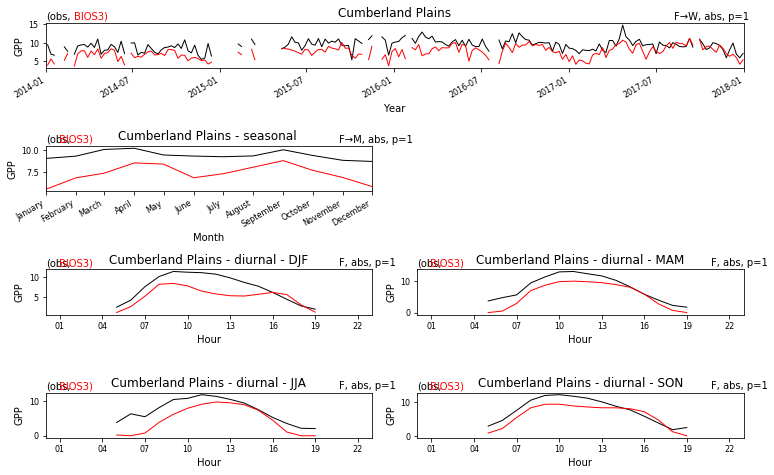

Plotting observations for  Rec
Plotting observations for  Rec
Plotting observations for  Rec
Plotting observations for  Rec
Plotting observations for  Rec
Plotting observations for  Rec


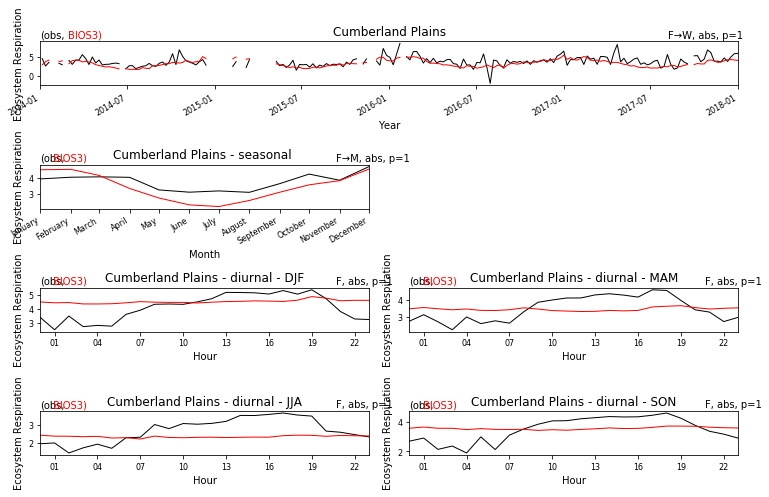

Plotting observations for  NEP
Plotting observations for  NEP
Plotting observations for  NEP
Plotting observations for  NEP
Plotting observations for  NEP
Plotting observations for  NEP


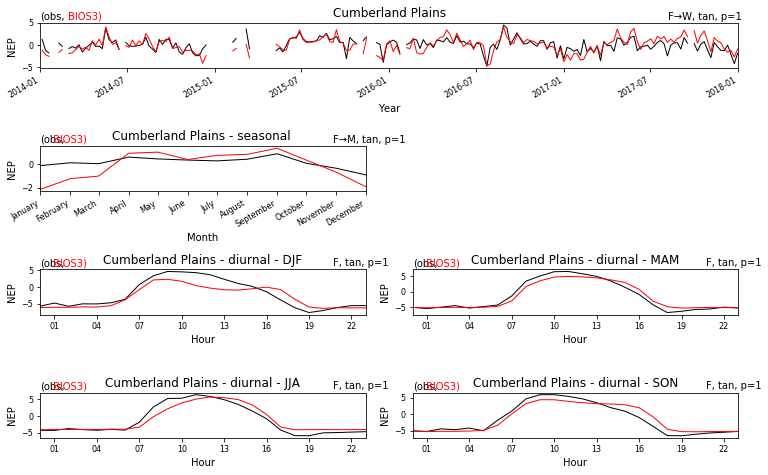

Plotting observations for  EvT
Plotting observations for  EvT
Plotting observations for  EvT
Plotting observations for  EvT
Plotting observations for  EvT
Plotting observations for  EvT


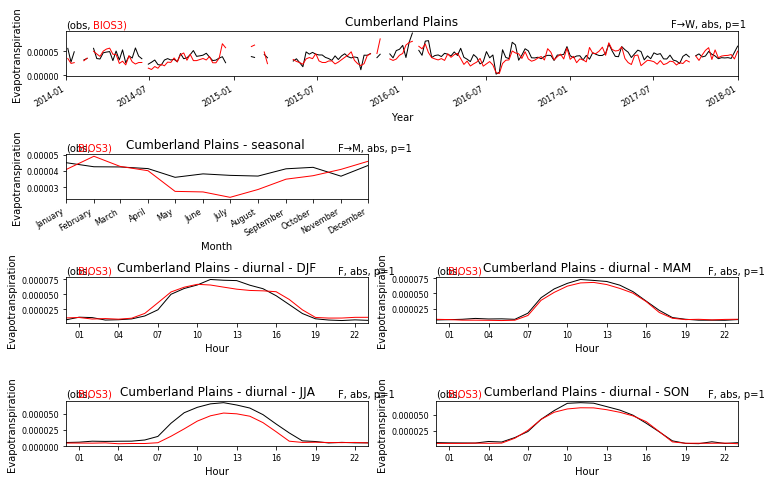

Plotting observations for  SMF
Plotting observations for  LAI


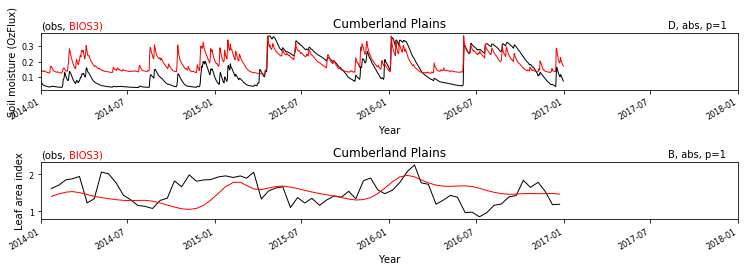

Plotting observations for  Rso
Plotting observations for  Rso
Plotting observations for  Rso
Plotting observations for  Rso
Plotting observations for  Rso
Plotting observations for  Rso


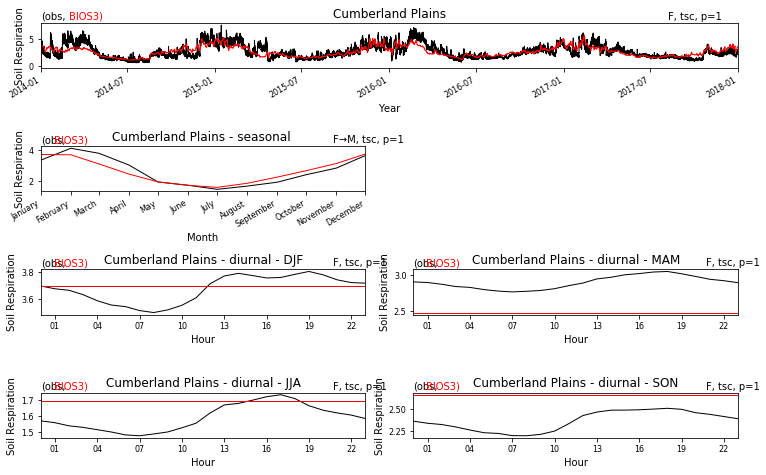

In [17]:
# Plot timeseries plots of observations and model observables
tsmin = datetime.datetime(2000,1,1,0,0)  
tsmax = datetime.datetime(2018,1,1,0,0)
if (domain == 'Cumberland'):
    tsmin = datetime.datetime(2014,1,1,0,0)
    tsmax = datetime.datetime(2018,1,1,0,0)
if (domain == 'Tumbarumba'):
    tsmin = datetime.datetime(2002,1,1,0,0)
    tsmax = datetime.datetime(2018,1,1,0,0)    
if (domain == 'Wombat'):
    tsmin = datetime.datetime(2013,12,1,0,0)
    tsmax = datetime.datetime(2018,1,1,0,0)
if (domain == 'Warra'):
    tsmin = datetime.datetime(2015,1,1,0,0)
    tsmax = datetime.datetime(2018,1,1,0,0)    
    
# Plot different variables together (suits single site domain)    
if ((domain == 'Cumberland') or (domain == 'Tumbarumba') or (domain == 'Wombat') or (domain == 'Warra')):
    nhoriz = 1
    nvert = 4
    fig = plt.figure(figsize=(10.5, 6.7))
    PlotTimeseries_OneSite(df,'GPP','W','false',nvert,nhoriz,0,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(df,'GPP','M','seasonal',nvert,2,1,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(filter_by_season(df,1),'GPP','native','diurnal',nvert,2,2,0,'notlast','GPP',fig, ' - DJF')
    PlotTimeseries_OneSite(filter_by_season(df,2),'GPP','native','diurnal',nvert,2,2,1,'notlast','GPP',fig, ' - MAM')
    PlotTimeseries_OneSite(filter_by_season(df,3),'GPP','native','diurnal',nvert,2,3,0,'notlast','GPP',fig, ' - JJA')
    PlotTimeseries_OneSite(filter_by_season(df,4),'GPP','native','diurnal',nvert,2,3,1,'last','GPP',fig, ' - SON')
    fig = plt.figure(figsize=(10.5, 6.7))
    PlotTimeseries_OneSite(df,'Rec','W','false',nvert,nhoriz,0,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(df,'Rec','M','seasonal',nvert,2,1,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(filter_by_season(df,1),'Rec','native','diurnal',nvert,2,2,0,'notlast','Rec',fig, ' - DJF')
    PlotTimeseries_OneSite(filter_by_season(df,2),'Rec','native','diurnal',nvert,2,2,1,'notlast','Rec',fig, ' - MAM')
    PlotTimeseries_OneSite(filter_by_season(df,3),'Rec','native','diurnal',nvert,2,3,0,'notlast','Rec',fig, ' - JJA')
    PlotTimeseries_OneSite(filter_by_season(df,4),'Rec','native','diurnal',nvert,2,3,1,'last','Rec',fig, ' - SON')
    fig = plt.figure(figsize=(10.5, 6.7))
    PlotTimeseries_OneSite(df,'NEP','W','false',nvert,nhoriz,0,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(df,'NEP','M','seasonal',nvert,2,1,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(filter_by_season(df,1),'NEP','native','diurnal',nvert,2,2,0,'notlast','NEP',fig, ' - DJF')
    PlotTimeseries_OneSite(filter_by_season(df,2),'NEP','native','diurnal',nvert,2,2,1,'notlast','NEP',fig, ' - MAM')
    PlotTimeseries_OneSite(filter_by_season(df,3),'NEP','native','diurnal',nvert,2,3,0,'notlast','NEP',fig, ' - JJA')
    PlotTimeseries_OneSite(filter_by_season(df,4),'NEP','native','diurnal',nvert,2,3,1,'last','NEP',fig, ' - SON')
    fig = plt.figure(figsize=(10.5, 6.7))
    PlotTimeseries_OneSite(df,'EvT','W','false',nvert,nhoriz,0,0,'notlast','nil',fig) 
    PlotTimeseries_OneSite(df,'EvT','M','seasonal',nvert,2,1,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(filter_by_season(df,1),'EvT','native','diurnal',nvert,2,2,0,'notlast','EvT',fig, ' - DJF')
    PlotTimeseries_OneSite(filter_by_season(df,2),'EvT','native','diurnal',nvert,2,2,1,'notlast','EvT',fig, ' - MAM')
    PlotTimeseries_OneSite(filter_by_season(df,3),'EvT','native','diurnal',nvert,2,3,0,'notlast','EvT',fig, ' - JJA')
    PlotTimeseries_OneSite(filter_by_season(df,4),'EvT','native','diurnal',nvert,2,3,1,'last','EvT',fig, ' - SON')
    fig = plt.figure(figsize=(10.5, 6.7))
    PlotTimeseries_OneSite(df,'SMF','native','false',nvert,nhoriz,0,0,'notlast','nil',fig)
    PlotTimeseries_OneSite(df,'LAI','native','false',nvert,nhoriz,1,0,'last','SMF_LAI',fig)
    fig = plt.figure(figsize=(10.5, 6.7))   
    PlotTimeseries_OneSite(df,'Rso','native','false',nvert,nhoriz,0,0,'notlast','Rso',fig)
    PlotTimeseries_OneSite(df,'Rso','M','seasonal',nvert,2,1,0,'notlast','Rso',fig)
    PlotTimeseries_OneSite(filter_by_season(df,1),'Rso','native','diurnal',nvert,2,2,0,'notlast','Rso',fig, ' - DJF')
    PlotTimeseries_OneSite(filter_by_season(df,2),'Rso','native','diurnal',nvert,2,2,1,'notlast','Rso',fig, ' - MAM')
    PlotTimeseries_OneSite(filter_by_season(df,3),'Rso','native','diurnal',nvert,2,3,0,'notlast','Rso',fig, ' - JJA')
    PlotTimeseries_OneSite(filter_by_season(df,4),'Rso','native','diurnal',nvert,2,3,1,'last','Rso',fig, ' - SON')
   # tsmin = datetime.datetime(1990,1,1,0,0)
   # PlotTimeseries(df,'STR',nvert,nhoriz,2,0,'last','LAI_EvT_STR')
   # PlotTimeseries(df,'SMO',nvert,nhoriz,0,0,'notlast','nil')
   # tsmin = datetime.datetime(2010,1,1,0,0)
   # PlotTimeseries(df,'SMC',nvert,nhoriz,1,0,'notlast','nil')
   # tsmin = datetime.datetime(2014,1,1,0,0) 
   # tsmin = datetime.datetime(1990,1,1,0,0)    
else:  # plot each variable in a separate file (suits multi-site domain) 
    nvert = 3
    nhoriz = 1
    PlotTimeseries(df,'GPP','native','false',nvert,nhoriz)
    PlotTimeseries(df,'GPP','native','seasonal',nvert,nhoriz)
    PlotTimeseries(df,'GPP','M','seasonal',nvert,nhoriz)
    PlotTimeseries(df,'Rec','native','false',nvert,nhoriz)
    PlotTimeseries(df,'NEP','W','false',nvert,nhoriz)
    PlotTimeseries(df,'LAI','native','false',nvert,nhoriz)
    PlotTimeseries(df,'EvT','native','false',nvert,nhoriz)
    nhoriz = 1
    PlotTimeseries(df,'SMO','native','false',nvert,nhoriz)
    tsmin = datetime.datetime(2010,1,1,0,0)
    PlotTimeseries(df,'SMC','native','false',nvert,nhoriz)
    tsmin = datetime.datetime(1990,1,1,0,0)
    PlotTimeseries(df,'STR','native','false',nvert,nhoriz)     

In [18]:
15/1e6*3600*24*365*12*1e4/1e6/2

28.382400000000004

In [19]:
147680/4

36920.0